In [106]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

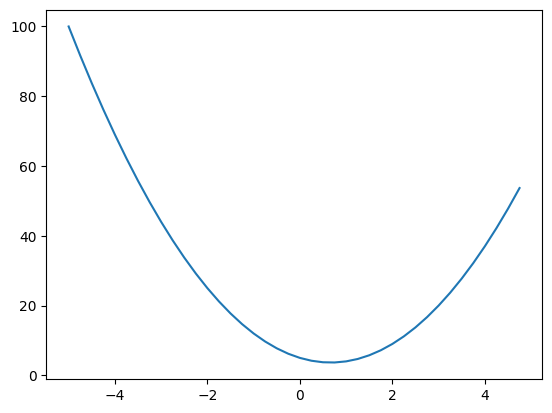

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.0001
x=3.0
(f(x+h) - f(x))/h

14.000300000063248

In [6]:
a= 2.0
b=-3.0
c=10.0
d = a*b+c
print(d)

4.0


In [7]:
h=0.0001

#inputs
a = 2.0
b=-3.0
c = 10.0

d1 = a*b+c
a+=h
d2 = a*b+c

print('d1', d1)
print('d2', d2)


d1 4.0
d2 3.999699999999999


In [100]:
class Value:

  def __init__(self,data, _children=(), _op='', label='') -> None:
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self) -> str:
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self,other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other): # other + self
    return self + other

  def __sub__(self, other): # self - other
    return self + (-other)

  def __rsub__(self, other): # other - self
    return other + (-self)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out= Value(self.data * other.data, (self,other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a+b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

In [92]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes,  edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}"% (n.label, n.data, n.grad), shape='record')
    if n._op:
      #if this value is a result of some operation, create an op node for it
      dot.node(name= uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

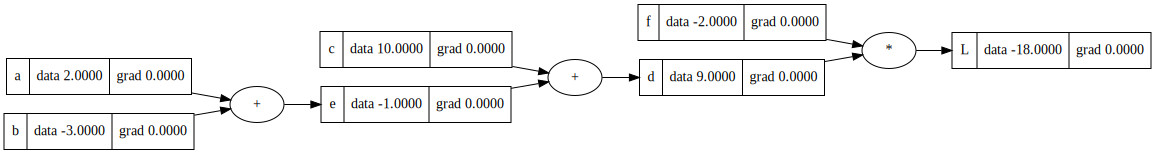

In [45]:
draw_dot(L)

In [46]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-8.0


In [47]:
L.grad = 1.0

In [48]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * -2.0

In [49]:
c.grad = -2.0
e.grad = -2.0

In [50]:
f.grad = 4.0
d.grad = -2

In [51]:
def lol():
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e+c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L1 = L.data

  h = 0.0001

  a = Value(2.0+h, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e+c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

lol()


6.000000000021544


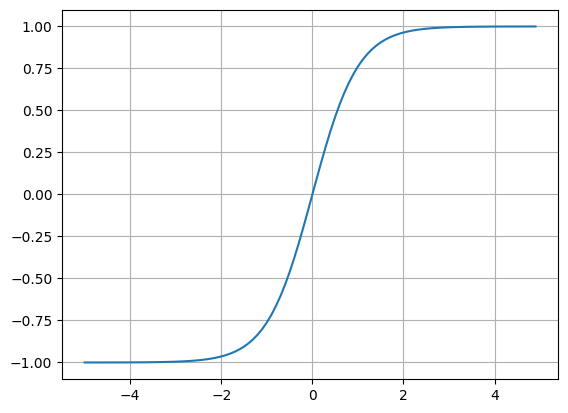

In [52]:
plt.plot(np.arange(-5,5,0.1), np.tanh(np.arange(-5,5,0.1))); plt.grid();

In [93]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b= Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


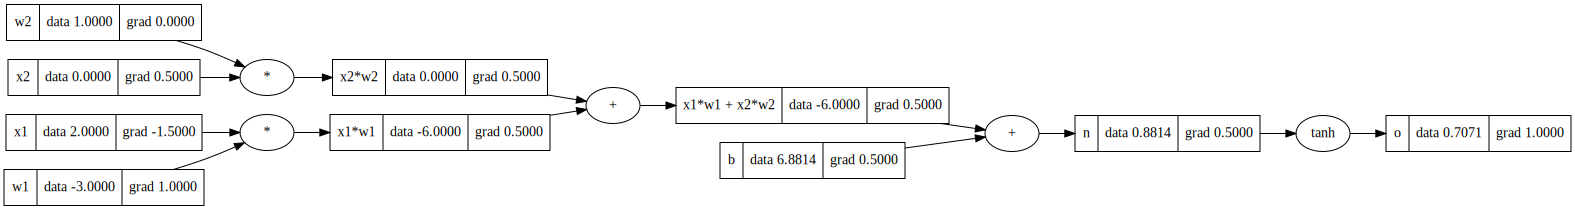

In [96]:
draw_dot(o)

In [95]:
o.backward()

In [89]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

In [77]:
o.grad = 1.0

In [78]:
o._backward()

In [80]:
n._backward()

In [82]:
b._backward()
x1w1x2w2._backward()

In [84]:
x1w1._backward()
x2w2._backward()

In [70]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [68]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [67]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [64]:
n.grad = 0.5

In [65]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [62]:
o.grad = 1.0

In [101]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b= Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()

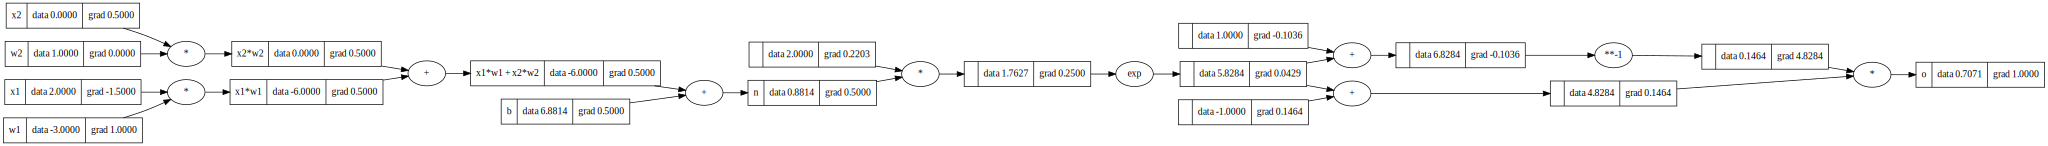

In [102]:
draw_dot(o)

In [103]:
import torch

x1 = torch.Tensor([2.0]).double()                     ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                     ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                    ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                     ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()      ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item)
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

<built-in method item of Tensor object at 0x7c5ddf8ab950>
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [129]:
class Neuron:
  def __init__(self, nin) -> None:
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w*x + b
    act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self,nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [335]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6236897835347076)

In [199]:
len(n.parameters())

41

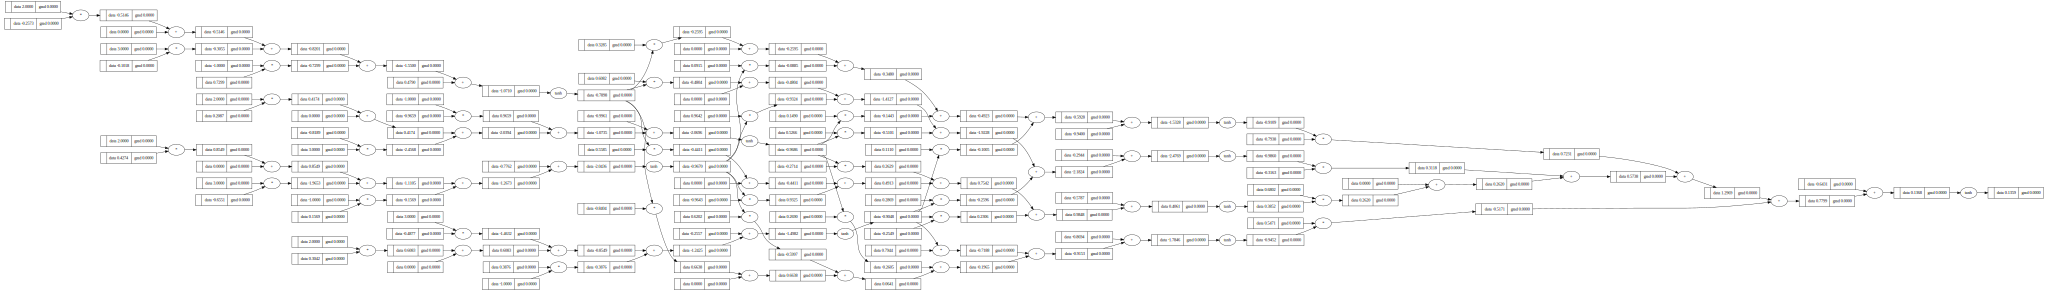

In [200]:
draw_dot(n(x))

In [336]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.6236897835347076),
 Value(data=0.8016119832420993),
 Value(data=0.8906175608166715),
 Value(data=0.5854860220645186)]

In [381]:
for k in range(10):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])

  for p in n.parameters():
    p.grad = 0

  # backward pass
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)


0 0.001708312409894309
1 0.0017035208595433298
2 0.001698755072409644
3 0.0016940148446231995
4 0.0016892999744397897
5 0.001684610262213621
6 0.001679945510370198
7 0.001675305523379772
8 0.00167069010773108
9 0.0016660990719054429


In [380]:
ypred

[Value(data=0.9847759877942303),
 Value(data=-0.985555026183054),
 Value(data=-0.974205368844064),
 Value(data=0.9753557488082518)]